# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0 -1.139678  0.376798  1.0  0.481657 -1.976460 -1.565492  1  2  14.424988   
1 -1.487004 -0.866999  1.0  0.891529 -1.656043  0.601124  3  0  15.535243   
2 -2.846174 -0.411779  1.0  0.505546 -0.921121 -0.498449  1  0  12.147642   
3 -1.810018  0.505204  1.0  0.584927 -0.377332 -0.025346  1  2  28.093158   
4 -0.260961 -0.083155  1.0  0.635962 -0.898638 -0.474116  3  0  14.734871   

            y  
0   94.606721  
1   25.284846  
2  -24.335424  
3  141.068777  
4  126.713651  
True causal estimate is 3.859817328248521


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

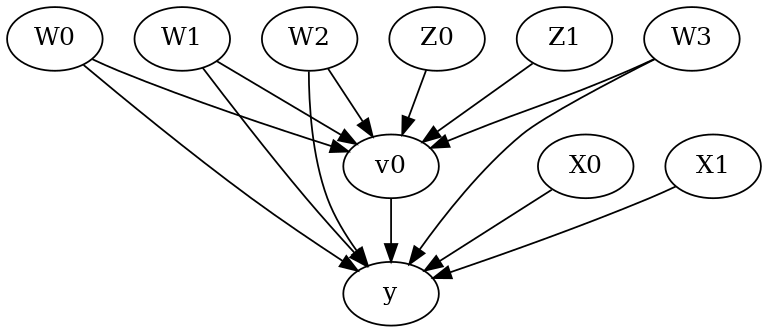

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W1,W2,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W1,W2,W0,U) = P(y|v0,W3,W1,W2,W0)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W1,W2,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W1,W2,W0,U) = P(y|v0,W3,W1,W2,W0)

## Realized estimand
b: y~v0+W3+W1+W2+W0+v0*X1+v0*X0
Target units: ate

## Estimate
Mean value: 3.860007413016712



## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W1,W2,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W1,W2,W0,U) = P(y|v0,W3,W1,W2,W0)

## Realized estimand
b: y~v0+W3+W1+W2+W0 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 12.720436965995988
Effect estimates: [[11.92302099]
 [12.34331302]
 [10.01846489]
 [10.46438894]
 [18.09201303]
 [13.93860441]
 [ 8.87936875]
 [14.51166189]
 [ 7.86731183]
 [10.5322804 ]
 [16.34289323]
 [10.87071427]
 [11.8050526 ]
 [24.17451045]
 [12.06723651]
 [ 9.48024167]
 [ 5.11248715]
 [10.10558891]
 [13.24255223]
 [ 9.40723886]
 [13.12887017]
 [13.60104903]
 [ 7.82838681]
 [15.70700713]
 [13.18430119]
 [ 6.11455904]
 [14.91950188]
 [ 9.24326621]
 [13.89586403]
 [14.20779895]
 [11.04572236]
 [16.77602006]
 [10.32611199]
 [13.868

In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 3.859817328248521


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W1,W2,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W1,W2,W0,U) = P(y|v0,W3,W1,W2,W0)

## Realized estimand
b: y~v0+W3+W1+W2+W0 | X1,X0
Target units: 

## Estimate
Mean value: 3.969326578729081
Effect estimates: [[ 7.29582086]
 [ 1.92815734]
 [-1.99117563]
 ...
 [13.32252088]
 [ 2.35166761]
 [-5.98717298]]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W1,W2,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W1,W2,W0,U) = P(y|v0,W3,W1,W2,W0)

## Realized estimand
b: y~v0+W3+W1+W2+W0 | X1,X0
Target units: ate

## Estimate
Mean value: 4.018591979356649
Effect estimates: [[ 7.2973789 ]
 [ 1.95906891]
 [-2.02495275]
 ...
 [13.35051274]
 [ 2.37250833]
 [-5.93917981]]



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[[14.60220855]
 [16.1024444 ]
 [13.80220789]
 [15.15581876]
 [14.15690416]
 [16.14399702]
 [13.30103866]
 [16.03904845]
 [13.59361577]
 [15.05822401]]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0    -1.031666 -0.676004  0.0  0.048095  0.304211  1.057433  0.753802   
1    -0.723289  1.211224  0.0  0.429334  1.689972 -0.065898 -0.420588   
2    -0.111164  0.964640  0.0  0.192904 -0.293054  1.326678 -1.338993   
3     0.717750  1.585226  0.0  0.178885  0.977203 -1.212051  0.851419   
4    -0.047097  2.195409  0.0  0.325146  1.593862 -0.800925 -0.575807   
...        ...       ...  ...       ...       ...       ...       ...   
9995 -0.006959 -1.434996  0.0  0.814772  1.928532  0.488331 -1.356220   
9996  0.868295 -0.215757  0.0  0.011453 -0.319300 -1.272306 -0.257379   
9997  1.455640  1.544373  0.0  0.228082 -0.168873  0.001067 -0.533737   
9998  0.275809 -0.012997  0.0  0.832838 -1.168387  0.047412 -0.926547   
9999  0.228798  1.629531  0.0  0.657545  2.415097 -1.906546  0.857451   

            W3  v0  y  
0     1.056604   1  1  
1     1.492395   1  1  
2     0.597437   1  1  
3    -1.248664   1  1  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.dr.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W1,W2,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W1,W2,W0,U) = P(y|v0,W3,W1,W2,W0)

## Realized estimand
b: y~v0+W3+W1+W2+W0 | X1,X0
Target units: ate

## Estimate
Mean value: 0.7844719745032825
Effect estimates: [[0.62888753]
 [0.74144192]
 [0.7598003 ]
 ...
 [0.86898065]
 [0.72920186]
 [0.81117764]]

True causal estimate is 0.6291


### Instrumental Variable Method

In [16]:
import keras
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.iv.nnet.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2022-12-06 09:31:36.591290: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 09:31:36.740590: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-06 09:31:36.740626: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2022-12-06 09:31:37.492796: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-06 09:31:37.492921: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-06 09:31:37.492932: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


2022-12-06 09:31:38.357701: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-06 09:31:38.357734: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-06 09:31:38.357758: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (780bf0ca5803): /proc/driver/nvidia/version does not exist
2022-12-06 09:31:38.358307: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 5:35 - loss: 185.7350

 34/313 [==>...........................] - ETA: 0s - loss: 65.3016   

 67/313 [=====>........................] - ETA: 0s - loss: 36.1540

102/313 [========>.....................] - ETA: 0s - loss: 25.4849

136/313 [============>.................] - ETA: 0s - loss: 20.3158

169/313 [===============>..............] - ETA: 0s - loss: 17.2464

204/313 [==================>...........] - ETA: 0s - loss: 15.0685

237/313 [=====================>........] - ETA: 0s - loss: 13.5794

271/313 [========================>.....] - ETA: 0s - loss: 12.4176

305/313 [============================>.] - ETA: 0s - loss: 11.5045

313/313 [==============================] - 2s 2ms/step - loss: 11.3145


Epoch 2/25


  1/313 [..............................] - ETA: 0s - loss: 4.0352

 35/313 [==>...........................] - ETA: 0s - loss: 4.0322

 68/313 [=====>........................] - ETA: 0s - loss: 4.0360

101/313 [========>.....................] - ETA: 0s - loss: 4.0028

132/313 [===========>..................] - ETA: 0s - loss: 3.9638

166/313 [==============>...............] - ETA: 0s - loss: 3.9319

200/313 [==================>...........] - ETA: 0s - loss: 3.8892

234/313 [=====================>........] - ETA: 0s - loss: 3.8382

267/313 [========================>.....] - ETA: 0s - loss: 3.7895

301/313 [===========================>..] - ETA: 0s - loss: 3.7313

313/313 [==============================] - 0s 2ms/step - loss: 3.7139


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 3.0330

 35/313 [==>...........................] - ETA: 0s - loss: 3.1224

 69/313 [=====>........................] - ETA: 0s - loss: 3.1255

102/313 [========>.....................] - ETA: 0s - loss: 3.1162

128/313 [===========>..................] - ETA: 0s - loss: 3.1102

155/313 [=============>................] - ETA: 0s - loss: 3.1027

180/313 [================>.............] - ETA: 0s - loss: 3.0957

202/313 [==================>...........] - ETA: 0s - loss: 3.0789

230/313 [=====================>........] - ETA: 0s - loss: 3.0710

258/313 [=======================>......] - ETA: 0s - loss: 3.0674

283/313 [==========================>...] - ETA: 0s - loss: 3.0573

307/313 [============================>.] - ETA: 0s - loss: 3.0472

313/313 [==============================] - 1s 2ms/step - loss: 3.0487


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 2.8622

 28/313 [=>............................] - ETA: 0s - loss: 2.9568

 55/313 [====>.........................] - ETA: 0s - loss: 2.9718

 82/313 [======>.......................] - ETA: 0s - loss: 2.9820

115/313 [==========>...................] - ETA: 0s - loss: 2.9684

144/313 [============>.................] - ETA: 0s - loss: 2.9612

179/313 [================>.............] - ETA: 0s - loss: 2.9621

214/313 [===================>..........] - ETA: 0s - loss: 2.9569

249/313 [======================>.......] - ETA: 0s - loss: 2.9533

284/313 [==========================>...] - ETA: 0s - loss: 2.9536

313/313 [==============================] - 1s 2ms/step - loss: 2.9475


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 2.7529

 36/313 [==>...........................] - ETA: 0s - loss: 2.8920

 70/313 [=====>........................] - ETA: 0s - loss: 2.8954

103/313 [========>.....................] - ETA: 0s - loss: 2.8987

138/313 [============>.................] - ETA: 0s - loss: 2.9012

174/313 [===============>..............] - ETA: 0s - loss: 2.8963

208/313 [==================>...........] - ETA: 0s - loss: 2.8987

239/313 [=====================>........] - ETA: 0s - loss: 2.8934

274/313 [=========================>....] - ETA: 0s - loss: 2.8896

309/313 [============================>.] - ETA: 0s - loss: 2.8883

313/313 [==============================] - 0s 1ms/step - loss: 2.8864


Epoch 6/25


  1/313 [..............................] - ETA: 0s - loss: 2.8771

 37/313 [==>...........................] - ETA: 0s - loss: 2.8744

 71/313 [=====>........................] - ETA: 0s - loss: 2.8674

103/313 [========>.....................] - ETA: 0s - loss: 2.8742

136/313 [============>.................] - ETA: 0s - loss: 2.8761

169/313 [===============>..............] - ETA: 0s - loss: 2.8725

201/313 [==================>...........] - ETA: 0s - loss: 2.8750

230/313 [=====================>........] - ETA: 0s - loss: 2.8696

264/313 [========================>.....] - ETA: 0s - loss: 2.8674

299/313 [===========================>..] - ETA: 0s - loss: 2.8643

313/313 [==============================] - 0s 2ms/step - loss: 2.8635


Epoch 7/25


  1/313 [..............................] - ETA: 0s - loss: 2.7894

 34/313 [==>...........................] - ETA: 0s - loss: 2.8510

 67/313 [=====>........................] - ETA: 0s - loss: 2.8558

 99/313 [========>.....................] - ETA: 0s - loss: 2.8589

132/313 [===========>..................] - ETA: 0s - loss: 2.8583

168/313 [===============>..............] - ETA: 0s - loss: 2.8589

203/313 [==================>...........] - ETA: 0s - loss: 2.8625

238/313 [=====================>........] - ETA: 0s - loss: 2.8599

273/313 [=========================>....] - ETA: 0s - loss: 2.8583

307/313 [============================>.] - ETA: 0s - loss: 2.8582

313/313 [==============================] - 0s 2ms/step - loss: 2.8577


Epoch 8/25


  1/313 [..............................] - ETA: 0s - loss: 2.8444

 36/313 [==>...........................] - ETA: 0s - loss: 2.8641

 70/313 [=====>........................] - ETA: 0s - loss: 2.8394

105/313 [=========>....................] - ETA: 0s - loss: 2.8245

138/313 [============>.................] - ETA: 0s - loss: 2.8309

173/313 [===============>..............] - ETA: 0s - loss: 2.8300

206/313 [==================>...........] - ETA: 0s - loss: 2.8288

239/313 [=====================>........] - ETA: 0s - loss: 2.8331

274/313 [=========================>....] - ETA: 0s - loss: 2.8290

308/313 [============================>.] - ETA: 0s - loss: 2.8288

313/313 [==============================] - 0s 1ms/step - loss: 2.8300


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 2.8264

 35/313 [==>...........................] - ETA: 0s - loss: 2.8266

 70/313 [=====>........................] - ETA: 0s - loss: 2.7989

101/313 [========>.....................] - ETA: 0s - loss: 2.8006

133/313 [===========>..................] - ETA: 0s - loss: 2.8089

166/313 [==============>...............] - ETA: 0s - loss: 2.8105

201/313 [==================>...........] - ETA: 0s - loss: 2.8108

236/313 [=====================>........] - ETA: 0s - loss: 2.8118

271/313 [========================>.....] - ETA: 0s - loss: 2.8095

306/313 [============================>.] - ETA: 0s - loss: 2.8032

313/313 [==============================] - 0s 2ms/step - loss: 2.8035


Epoch 10/25


  1/313 [..............................] - ETA: 0s - loss: 2.7123

 36/313 [==>...........................] - ETA: 0s - loss: 2.7827

 71/313 [=====>........................] - ETA: 0s - loss: 2.8097

105/313 [=========>....................] - ETA: 0s - loss: 2.8071

139/313 [============>.................] - ETA: 0s - loss: 2.8020

173/313 [===============>..............] - ETA: 0s - loss: 2.7921

208/313 [==================>...........] - ETA: 0s - loss: 2.7893

241/313 [======================>.......] - ETA: 0s - loss: 2.7852

276/313 [=========================>....] - ETA: 0s - loss: 2.7792

310/313 [============================>.] - ETA: 0s - loss: 2.7773

313/313 [==============================] - 0s 1ms/step - loss: 2.7792


Epoch 11/25


  1/313 [..............................] - ETA: 0s - loss: 2.7608

 35/313 [==>...........................] - ETA: 0s - loss: 2.8039

 69/313 [=====>........................] - ETA: 0s - loss: 2.7829

104/313 [========>.....................] - ETA: 0s - loss: 2.7744

139/313 [============>.................] - ETA: 0s - loss: 2.7731

174/313 [===============>..............] - ETA: 0s - loss: 2.7671

210/313 [===================>..........] - ETA: 0s - loss: 2.7689

245/313 [======================>.......] - ETA: 0s - loss: 2.7625

279/313 [=========================>....] - ETA: 0s - loss: 2.7602

313/313 [==============================] - 0s 1ms/step - loss: 2.7572


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 2.7644

 35/313 [==>...........................] - ETA: 0s - loss: 2.7681

 68/313 [=====>........................] - ETA: 0s - loss: 2.7587

103/313 [========>.....................] - ETA: 0s - loss: 2.7674

136/313 [============>.................] - ETA: 0s - loss: 2.7721

169/313 [===============>..............] - ETA: 0s - loss: 2.7620

202/313 [==================>...........] - ETA: 0s - loss: 2.7598

233/313 [=====================>........] - ETA: 0s - loss: 2.7543

268/313 [========================>.....] - ETA: 0s - loss: 2.7491

302/313 [===========================>..] - ETA: 0s - loss: 2.7509

313/313 [==============================] - 0s 2ms/step - loss: 2.7487


Epoch 13/25


  1/313 [..............................] - ETA: 0s - loss: 2.6876

 35/313 [==>...........................] - ETA: 0s - loss: 2.7815

 69/313 [=====>........................] - ETA: 0s - loss: 2.7666

103/313 [========>.....................] - ETA: 0s - loss: 2.7625

137/313 [============>.................] - ETA: 0s - loss: 2.7664

171/313 [===============>..............] - ETA: 0s - loss: 2.7566

205/313 [==================>...........] - ETA: 0s - loss: 2.7522

238/313 [=====================>........] - ETA: 0s - loss: 2.7474

272/313 [=========================>....] - ETA: 0s - loss: 2.7449

307/313 [============================>.] - ETA: 0s - loss: 2.7397

313/313 [==============================] - 0s 2ms/step - loss: 2.7400


Epoch 14/25


  1/313 [..............................] - ETA: 0s - loss: 2.6973

 37/313 [==>...........................] - ETA: 0s - loss: 2.7235

 72/313 [=====>........................] - ETA: 0s - loss: 2.7409

105/313 [=========>....................] - ETA: 0s - loss: 2.7384

139/313 [============>.................] - ETA: 0s - loss: 2.7276

174/313 [===============>..............] - ETA: 0s - loss: 2.7270

209/313 [===================>..........] - ETA: 0s - loss: 2.7321

243/313 [======================>.......] - ETA: 0s - loss: 2.7311

275/313 [=========================>....] - ETA: 0s - loss: 2.7353

307/313 [============================>.] - ETA: 0s - loss: 2.7322

313/313 [==============================] - 0s 1ms/step - loss: 2.7319


Epoch 15/25


  1/313 [..............................] - ETA: 0s - loss: 2.7594

 34/313 [==>...........................] - ETA: 0s - loss: 2.7202

 67/313 [=====>........................] - ETA: 0s - loss: 2.7504

102/313 [========>.....................] - ETA: 0s - loss: 2.7442

135/313 [===========>..................] - ETA: 0s - loss: 2.7448

169/313 [===============>..............] - ETA: 0s - loss: 2.7412

203/313 [==================>...........] - ETA: 0s - loss: 2.7399

237/313 [=====================>........] - ETA: 0s - loss: 2.7344

271/313 [========================>.....] - ETA: 0s - loss: 2.7323

305/313 [============================>.] - ETA: 0s - loss: 2.7326

313/313 [==============================] - 0s 2ms/step - loss: 2.7320


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 2.6655

 35/313 [==>...........................] - ETA: 0s - loss: 2.7501

 68/313 [=====>........................] - ETA: 0s - loss: 2.7204

101/313 [========>.....................] - ETA: 0s - loss: 2.7239

135/313 [===========>..................] - ETA: 0s - loss: 2.7196

170/313 [===============>..............] - ETA: 0s - loss: 2.7169

205/313 [==================>...........] - ETA: 0s - loss: 2.7225

238/313 [=====================>........] - ETA: 0s - loss: 2.7189

272/313 [=========================>....] - ETA: 0s - loss: 2.7203

306/313 [============================>.] - ETA: 0s - loss: 2.7225

313/313 [==============================] - 0s 2ms/step - loss: 2.7215


Epoch 17/25


  1/313 [..............................] - ETA: 0s - loss: 2.7377

 36/313 [==>...........................] - ETA: 0s - loss: 2.6877

 71/313 [=====>........................] - ETA: 0s - loss: 2.6924

103/313 [========>.....................] - ETA: 0s - loss: 2.7022

137/313 [============>.................] - ETA: 0s - loss: 2.6950

171/313 [===============>..............] - ETA: 0s - loss: 2.6999

205/313 [==================>...........] - ETA: 0s - loss: 2.7072

240/313 [======================>.......] - ETA: 0s - loss: 2.7104

274/313 [=========================>....] - ETA: 0s - loss: 2.7126

308/313 [============================>.] - ETA: 0s - loss: 2.7087

313/313 [==============================] - 0s 1ms/step - loss: 2.7104


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 2.6107

 35/313 [==>...........................] - ETA: 0s - loss: 2.7352

 70/313 [=====>........................] - ETA: 0s - loss: 2.7301

104/313 [========>.....................] - ETA: 0s - loss: 2.7165

138/313 [============>.................] - ETA: 0s - loss: 2.7099

171/313 [===============>..............] - ETA: 0s - loss: 2.7117

206/313 [==================>...........] - ETA: 0s - loss: 2.7184

240/313 [======================>.......] - ETA: 0s - loss: 2.7139

274/313 [=========================>....] - ETA: 0s - loss: 2.7154

307/313 [============================>.] - ETA: 0s - loss: 2.7140

313/313 [==============================] - 0s 2ms/step - loss: 2.7143


Epoch 19/25


  1/313 [..............................] - ETA: 0s - loss: 2.7943

 36/313 [==>...........................] - ETA: 0s - loss: 2.7197

 69/313 [=====>........................] - ETA: 0s - loss: 2.7117

 99/313 [========>.....................] - ETA: 0s - loss: 2.7024

132/313 [===========>..................] - ETA: 0s - loss: 2.7020

163/313 [==============>...............] - ETA: 0s - loss: 2.7007

191/313 [=================>............] - ETA: 0s - loss: 2.7042

224/313 [====================>.........] - ETA: 0s - loss: 2.7017

258/313 [=======================>......] - ETA: 0s - loss: 2.7014

293/313 [===========================>..] - ETA: 0s - loss: 2.7017

313/313 [==============================] - 0s 2ms/step - loss: 2.6999


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 2.7659

 36/313 [==>...........................] - ETA: 0s - loss: 2.6864

 70/313 [=====>........................] - ETA: 0s - loss: 2.7116

104/313 [========>.....................] - ETA: 0s - loss: 2.7086

135/313 [===========>..................] - ETA: 0s - loss: 2.7045

169/313 [===============>..............] - ETA: 0s - loss: 2.6984

202/313 [==================>...........] - ETA: 0s - loss: 2.6918

235/313 [=====================>........] - ETA: 0s - loss: 2.6942

269/313 [========================>.....] - ETA: 0s - loss: 2.6984

302/313 [===========================>..] - ETA: 0s - loss: 2.7014

313/313 [==============================] - 0s 2ms/step - loss: 2.7023


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 2.6241

 36/313 [==>...........................] - ETA: 0s - loss: 2.6959

 68/313 [=====>........................] - ETA: 0s - loss: 2.6949

101/313 [========>.....................] - ETA: 0s - loss: 2.6933

134/313 [===========>..................] - ETA: 0s - loss: 2.7007

169/313 [===============>..............] - ETA: 0s - loss: 2.7070

203/313 [==================>...........] - ETA: 0s - loss: 2.7071

236/313 [=====================>........] - ETA: 0s - loss: 2.7032

269/313 [========================>.....] - ETA: 0s - loss: 2.7023

303/313 [============================>.] - ETA: 0s - loss: 2.7047

313/313 [==============================] - 0s 2ms/step - loss: 2.7044


Epoch 22/25


  1/313 [..............................] - ETA: 0s - loss: 2.4766

 35/313 [==>...........................] - ETA: 0s - loss: 2.6806

 67/313 [=====>........................] - ETA: 0s - loss: 2.6862

101/313 [========>.....................] - ETA: 0s - loss: 2.7056

136/313 [============>.................] - ETA: 0s - loss: 2.7048

171/313 [===============>..............] - ETA: 0s - loss: 2.7077

206/313 [==================>...........] - ETA: 0s - loss: 2.7077

240/313 [======================>.......] - ETA: 0s - loss: 2.7071

275/313 [=========================>....] - ETA: 0s - loss: 2.7026

309/313 [============================>.] - ETA: 0s - loss: 2.6972

313/313 [==============================] - 0s 1ms/step - loss: 2.6966


Epoch 23/25


  1/313 [..............................] - ETA: 0s - loss: 2.4903

 34/313 [==>...........................] - ETA: 0s - loss: 2.6761

 68/313 [=====>........................] - ETA: 0s - loss: 2.6718

100/313 [========>.....................] - ETA: 0s - loss: 2.6967

134/313 [===========>..................] - ETA: 0s - loss: 2.6907

165/313 [==============>...............] - ETA: 0s - loss: 2.6916

195/313 [=================>............] - ETA: 0s - loss: 2.6870

231/313 [=====================>........] - ETA: 0s - loss: 2.6862

265/313 [========================>.....] - ETA: 0s - loss: 2.6894

298/313 [===========================>..] - ETA: 0s - loss: 2.6896

313/313 [==============================] - 0s 2ms/step - loss: 2.6917


Epoch 24/25


  1/313 [..............................] - ETA: 0s - loss: 2.8008

 36/313 [==>...........................] - ETA: 0s - loss: 2.6957

 69/313 [=====>........................] - ETA: 0s - loss: 2.7023

102/313 [========>.....................] - ETA: 0s - loss: 2.6962

135/313 [===========>..................] - ETA: 0s - loss: 2.6935

167/313 [===============>..............] - ETA: 0s - loss: 2.6979

201/313 [==================>...........] - ETA: 0s - loss: 2.6928

235/313 [=====================>........] - ETA: 0s - loss: 2.6930

267/313 [========================>.....] - ETA: 0s - loss: 2.6958

301/313 [===========================>..] - ETA: 0s - loss: 2.6968

313/313 [==============================] - 0s 2ms/step - loss: 2.6949


Epoch 25/25


  1/313 [..............................] - ETA: 0s - loss: 2.6745

 35/313 [==>...........................] - ETA: 0s - loss: 2.6811

 69/313 [=====>........................] - ETA: 0s - loss: 2.6940

105/313 [=========>....................] - ETA: 0s - loss: 2.6972

141/313 [============>.................] - ETA: 0s - loss: 2.6978

176/313 [===============>..............] - ETA: 0s - loss: 2.6853

209/313 [===================>..........] - ETA: 0s - loss: 2.6851

243/313 [======================>.......] - ETA: 0s - loss: 2.6872

276/313 [=========================>....] - ETA: 0s - loss: 2.6833

310/313 [============================>.] - ETA: 0s - loss: 2.6867

313/313 [==============================] - 0s 1ms/step - loss: 2.6876


Epoch 1/25


  1/313 [..............................] - ETA: 7:48 - loss: 38983.1250

 29/313 [=>............................] - ETA: 0s - loss: 23441.4434  

 57/313 [====>.........................] - ETA: 0s - loss: 20364.7246

 85/313 [=======>......................] - ETA: 0s - loss: 18749.2090

114/313 [=========>....................] - ETA: 0s - loss: 18171.6680

142/313 [============>.................] - ETA: 0s - loss: 17502.3594

169/313 [===============>..............] - ETA: 0s - loss: 17028.1602

197/313 [=================>............] - ETA: 0s - loss: 16749.5664

225/313 [====================>.........] - ETA: 0s - loss: 16240.8076

253/313 [=======================>......] - ETA: 0s - loss: 15638.0400

279/313 [=========================>....] - ETA: 0s - loss: 15082.1182

305/313 [============================>.] - ETA: 0s - loss: 14554.6816

313/313 [==============================] - 2s 2ms/step - loss: 14380.6426


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 15698.7744

 29/313 [=>............................] - ETA: 0s - loss: 8715.0840 

 57/313 [====>.........................] - ETA: 0s - loss: 8382.7871

 85/313 [=======>......................] - ETA: 0s - loss: 8289.2871

112/313 [=========>....................] - ETA: 0s - loss: 8135.3091

140/313 [============>.................] - ETA: 0s - loss: 7876.0234

168/313 [===============>..............] - ETA: 0s - loss: 7582.1719

196/313 [=================>............] - ETA: 0s - loss: 7457.5098

221/313 [====================>.........] - ETA: 0s - loss: 7316.2607

248/313 [======================>.......] - ETA: 0s - loss: 7131.7271

276/313 [=========================>....] - ETA: 0s - loss: 7005.3008

304/313 [============================>.] - ETA: 0s - loss: 6896.9170

313/313 [==============================] - 1s 2ms/step - loss: 6956.3730


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 6351.7607

 29/313 [=>............................] - ETA: 0s - loss: 5012.0420

 57/313 [====>.........................] - ETA: 0s - loss: 7345.9141

 85/313 [=======>......................] - ETA: 0s - loss: 7203.6611

113/313 [=========>....................] - ETA: 0s - loss: 6837.0264

141/313 [============>.................] - ETA: 0s - loss: 6450.7217

169/313 [===============>..............] - ETA: 0s - loss: 6294.8159

197/313 [=================>............] - ETA: 0s - loss: 6228.7671

225/313 [====================>.........] - ETA: 0s - loss: 6146.6821

253/313 [=======================>......] - ETA: 0s - loss: 5959.9160

280/313 [=========================>....] - ETA: 0s - loss: 5907.1455

307/313 [============================>.] - ETA: 0s - loss: 5820.8433

313/313 [==============================] - 1s 2ms/step - loss: 5785.6792


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 6462.5635

 28/313 [=>............................] - ETA: 0s - loss: 4231.0522

 56/313 [====>.........................] - ETA: 0s - loss: 4280.0542

 84/313 [=======>......................] - ETA: 0s - loss: 4639.9346

110/313 [=========>....................] - ETA: 0s - loss: 4617.2539

137/313 [============>.................] - ETA: 0s - loss: 4612.3516

164/313 [==============>...............] - ETA: 0s - loss: 4613.9023

191/313 [=================>............] - ETA: 0s - loss: 4531.9697

219/313 [===================>..........] - ETA: 0s - loss: 4524.9941

247/313 [======================>.......] - ETA: 0s - loss: 4540.4917

275/313 [=========================>....] - ETA: 0s - loss: 4529.3242

303/313 [============================>.] - ETA: 0s - loss: 4524.7275

313/313 [==============================] - 1s 2ms/step - loss: 4512.2324


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 7864.1772

 27/313 [=>............................] - ETA: 0s - loss: 4548.0596

 54/313 [====>.........................] - ETA: 0s - loss: 4728.0942

 81/313 [======>.......................] - ETA: 0s - loss: 4739.9692

110/313 [=========>....................] - ETA: 0s - loss: 4620.3706

139/313 [============>.................] - ETA: 0s - loss: 4444.5020

166/313 [==============>...............] - ETA: 0s - loss: 4432.0171

194/313 [=================>............] - ETA: 0s - loss: 4379.3130

223/313 [====================>.........] - ETA: 0s - loss: 4272.9004

251/313 [=======================>......] - ETA: 0s - loss: 4279.0635

279/313 [=========================>....] - ETA: 0s - loss: 4255.4009

307/313 [============================>.] - ETA: 0s - loss: 4276.9824

313/313 [==============================] - 1s 2ms/step - loss: 4286.8223


Epoch 6/25


  1/313 [..............................] - ETA: 0s - loss: 4216.8340

 29/313 [=>............................] - ETA: 0s - loss: 3777.4739

 56/313 [====>.........................] - ETA: 0s - loss: 3871.3230

 84/313 [=======>......................] - ETA: 0s - loss: 3988.6699

112/313 [=========>....................] - ETA: 0s - loss: 3932.3464

140/313 [============>.................] - ETA: 0s - loss: 4032.1357

168/313 [===============>..............] - ETA: 0s - loss: 4098.9951

196/313 [=================>............] - ETA: 0s - loss: 4117.9570

224/313 [====================>.........] - ETA: 0s - loss: 4117.1348

252/313 [=======================>......] - ETA: 0s - loss: 4136.7739

280/313 [=========================>....] - ETA: 0s - loss: 4078.2705

308/313 [============================>.] - ETA: 0s - loss: 4102.2954

313/313 [==============================] - 1s 2ms/step - loss: 4080.0771


Epoch 7/25


  1/313 [..............................] - ETA: 0s - loss: 3714.8948

 29/313 [=>............................] - ETA: 0s - loss: 3954.9971

 57/313 [====>.........................] - ETA: 0s - loss: 4210.0420

 85/313 [=======>......................] - ETA: 0s - loss: 4161.0156

113/313 [=========>....................] - ETA: 0s - loss: 4101.5015

141/313 [============>.................] - ETA: 0s - loss: 4134.3384

169/313 [===============>..............] - ETA: 0s - loss: 4097.7500

197/313 [=================>............] - ETA: 0s - loss: 4172.7798

225/313 [====================>.........] - ETA: 0s - loss: 4252.9824

253/313 [=======================>......] - ETA: 0s - loss: 4225.8003

281/313 [=========================>....] - ETA: 0s - loss: 4333.3125

309/313 [============================>.] - ETA: 0s - loss: 4313.9956

313/313 [==============================] - 1s 2ms/step - loss: 4319.6016


Epoch 8/25


  1/313 [..............................] - ETA: 0s - loss: 3776.6172

 30/313 [=>............................] - ETA: 0s - loss: 4615.9385

 58/313 [====>.........................] - ETA: 0s - loss: 4321.2002

 86/313 [=======>......................] - ETA: 0s - loss: 4175.7910

114/313 [=========>....................] - ETA: 0s - loss: 4075.3953

142/313 [============>.................] - ETA: 0s - loss: 4074.8984

170/313 [===============>..............] - ETA: 0s - loss: 4093.1997

198/313 [=================>............] - ETA: 0s - loss: 4087.9871

225/313 [====================>.........] - ETA: 0s - loss: 4085.0630

252/313 [=======================>......] - ETA: 0s - loss: 4069.6416

280/313 [=========================>....] - ETA: 0s - loss: 4123.5601

308/313 [============================>.] - ETA: 0s - loss: 4126.1660

313/313 [==============================] - 1s 2ms/step - loss: 4135.0430


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 1749.3196

 29/313 [=>............................] - ETA: 0s - loss: 4335.0190

 57/313 [====>.........................] - ETA: 0s - loss: 4078.3040

 85/313 [=======>......................] - ETA: 0s - loss: 4028.6685

113/313 [=========>....................] - ETA: 0s - loss: 4037.7478

139/313 [============>.................] - ETA: 0s - loss: 4045.9695

167/313 [===============>..............] - ETA: 0s - loss: 3961.6453

195/313 [=================>............] - ETA: 0s - loss: 3974.4900

223/313 [====================>.........] - ETA: 0s - loss: 4028.3708

251/313 [=======================>......] - ETA: 0s - loss: 4006.8318

278/313 [=========================>....] - ETA: 0s - loss: 3939.4695

306/313 [============================>.] - ETA: 0s - loss: 3976.0208

313/313 [==============================] - 1s 2ms/step - loss: 3988.2073


Epoch 10/25


  1/313 [..............................] - ETA: 0s - loss: 2628.9502

 30/313 [=>............................] - ETA: 0s - loss: 3849.4170

 58/313 [====>.........................] - ETA: 0s - loss: 4322.4502

 85/313 [=======>......................] - ETA: 0s - loss: 4030.3044

111/313 [=========>....................] - ETA: 0s - loss: 3959.3828

139/313 [============>.................] - ETA: 0s - loss: 3887.1860

167/313 [===============>..............] - ETA: 0s - loss: 3935.7839

195/313 [=================>............] - ETA: 0s - loss: 4070.0095

223/313 [====================>.........] - ETA: 0s - loss: 4043.4263

251/313 [=======================>......] - ETA: 0s - loss: 4012.5420

279/313 [=========================>....] - ETA: 0s - loss: 4058.1367

307/313 [============================>.] - ETA: 0s - loss: 4037.7578

313/313 [==============================] - 1s 2ms/step - loss: 4028.9875


Epoch 11/25


  1/313 [..............................] - ETA: 0s - loss: 5341.2837

 30/313 [=>............................] - ETA: 0s - loss: 4686.5459

 58/313 [====>.........................] - ETA: 0s - loss: 4189.6812

 86/313 [=======>......................] - ETA: 0s - loss: 4091.2866

114/313 [=========>....................] - ETA: 0s - loss: 4066.4495

142/313 [============>.................] - ETA: 0s - loss: 4021.5374

170/313 [===============>..............] - ETA: 0s - loss: 3965.0168

198/313 [=================>............] - ETA: 0s - loss: 3943.3677

226/313 [====================>.........] - ETA: 0s - loss: 3969.0642

254/313 [=======================>......] - ETA: 0s - loss: 4013.7703

282/313 [==========================>...] - ETA: 0s - loss: 4025.6768

310/313 [============================>.] - ETA: 0s - loss: 4058.2202

313/313 [==============================] - 1s 2ms/step - loss: 4053.9436


Epoch 12/25


  1/313 [..............................] - ETA: 0s - loss: 1461.1816

 29/313 [=>............................] - ETA: 0s - loss: 4002.1770

 57/313 [====>.........................] - ETA: 0s - loss: 3981.4377

 85/313 [=======>......................] - ETA: 0s - loss: 3854.0522

113/313 [=========>....................] - ETA: 0s - loss: 3930.9412

141/313 [============>.................] - ETA: 0s - loss: 3950.2349

169/313 [===============>..............] - ETA: 0s - loss: 3878.1206

195/313 [=================>............] - ETA: 0s - loss: 3973.4324

221/313 [====================>.........] - ETA: 0s - loss: 4010.6892

248/313 [======================>.......] - ETA: 0s - loss: 3976.6174

275/313 [=========================>....] - ETA: 0s - loss: 4033.5222

303/313 [============================>.] - ETA: 0s - loss: 4030.9001

313/313 [==============================] - 1s 2ms/step - loss: 3989.8782


Epoch 13/25


  1/313 [..............................] - ETA: 0s - loss: 10046.3457

 29/313 [=>............................] - ETA: 0s - loss: 3999.0000 

 57/313 [====>.........................] - ETA: 0s - loss: 3985.0537

 86/313 [=======>......................] - ETA: 0s - loss: 3909.6116

115/313 [==========>...................] - ETA: 0s - loss: 3784.1614

143/313 [============>.................] - ETA: 0s - loss: 3794.4612

171/313 [===============>..............] - ETA: 0s - loss: 3768.7583

199/313 [==================>...........] - ETA: 0s - loss: 3782.8923

227/313 [====================>.........] - ETA: 0s - loss: 3824.7205

255/313 [=======================>......] - ETA: 0s - loss: 3877.1660

283/313 [==========================>...] - ETA: 0s - loss: 3927.3596

311/313 [============================>.] - ETA: 0s - loss: 3887.2170

313/313 [==============================] - 1s 2ms/step - loss: 3880.1321


Epoch 14/25


  1/313 [..............................] - ETA: 0s - loss: 2457.5034

 30/313 [=>............................] - ETA: 0s - loss: 4132.9253

 57/313 [====>.........................] - ETA: 0s - loss: 4084.7642

 85/313 [=======>......................] - ETA: 0s - loss: 4164.7954

112/313 [=========>....................] - ETA: 0s - loss: 4154.0474

139/313 [============>.................] - ETA: 0s - loss: 4147.2910

166/313 [==============>...............] - ETA: 0s - loss: 4095.2083

193/313 [=================>............] - ETA: 0s - loss: 4118.2051

221/313 [====================>.........] - ETA: 0s - loss: 4053.8201

249/313 [======================>.......] - ETA: 0s - loss: 4018.5774

277/313 [=========================>....] - ETA: 0s - loss: 4028.0759

303/313 [============================>.] - ETA: 0s - loss: 4023.8875

313/313 [==============================] - 1s 2ms/step - loss: 3997.8403


Epoch 15/25


  1/313 [..............................] - ETA: 0s - loss: 3472.6343

 29/313 [=>............................] - ETA: 0s - loss: 4154.9282

 57/313 [====>.........................] - ETA: 0s - loss: 4824.9590

 85/313 [=======>......................] - ETA: 0s - loss: 4463.0059

113/313 [=========>....................] - ETA: 0s - loss: 4452.0488

141/313 [============>.................] - ETA: 0s - loss: 4317.8042

169/313 [===============>..............] - ETA: 0s - loss: 4265.6709

197/313 [=================>............] - ETA: 0s - loss: 4171.4287

225/313 [====================>.........] - ETA: 0s - loss: 4136.7979

252/313 [=======================>......] - ETA: 0s - loss: 4123.8193

281/313 [=========================>....] - ETA: 0s - loss: 4159.2783

309/313 [============================>.] - ETA: 0s - loss: 4097.3184

313/313 [==============================] - 1s 2ms/step - loss: 4091.7065


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 3254.6655

 29/313 [=>............................] - ETA: 0s - loss: 4421.8018

 57/313 [====>.........................] - ETA: 0s - loss: 3860.5146

 85/313 [=======>......................] - ETA: 0s - loss: 4166.3311

113/313 [=========>....................] - ETA: 0s - loss: 4090.2021

140/313 [============>.................] - ETA: 0s - loss: 4084.7004

167/313 [===============>..............] - ETA: 0s - loss: 4076.4714

194/313 [=================>............] - ETA: 0s - loss: 4029.4146

222/313 [====================>.........] - ETA: 0s - loss: 4001.7048

250/313 [======================>.......] - ETA: 0s - loss: 3958.7144

278/313 [=========================>....] - ETA: 0s - loss: 3930.2285

306/313 [============================>.] - ETA: 0s - loss: 3941.3447

313/313 [==============================] - 1s 2ms/step - loss: 3943.5959


Epoch 17/25


  1/313 [..............................] - ETA: 0s - loss: 4640.5112

 30/313 [=>............................] - ETA: 0s - loss: 3646.5205

 58/313 [====>.........................] - ETA: 0s - loss: 3970.9744

 84/313 [=======>......................] - ETA: 0s - loss: 4026.0042

110/313 [=========>....................] - ETA: 0s - loss: 3963.0232

138/313 [============>.................] - ETA: 0s - loss: 3829.7300

166/313 [==============>...............] - ETA: 0s - loss: 3792.5054

194/313 [=================>............] - ETA: 0s - loss: 3860.6379

222/313 [====================>.........] - ETA: 0s - loss: 3803.5066

250/313 [======================>.......] - ETA: 0s - loss: 3839.2388

278/313 [=========================>....] - ETA: 0s - loss: 3885.5410

305/313 [============================>.] - ETA: 0s - loss: 3877.7263

313/313 [==============================] - 1s 2ms/step - loss: 3872.4724


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 3180.1548

 29/313 [=>............................] - ETA: 0s - loss: 3763.5544

 57/313 [====>.........................] - ETA: 0s - loss: 3893.7419

 85/313 [=======>......................] - ETA: 0s - loss: 3982.8738

113/313 [=========>....................] - ETA: 0s - loss: 3907.2063

140/313 [============>.................] - ETA: 0s - loss: 3839.6655

167/313 [===============>..............] - ETA: 0s - loss: 3819.1975

195/313 [=================>............] - ETA: 0s - loss: 3922.4058

223/313 [====================>.........] - ETA: 0s - loss: 3935.4949

251/313 [=======================>......] - ETA: 0s - loss: 3883.9866

279/313 [=========================>....] - ETA: 0s - loss: 3926.7581

307/313 [============================>.] - ETA: 0s - loss: 3918.9160

313/313 [==============================] - 1s 2ms/step - loss: 3904.8862


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 4048.8997

 29/313 [=>............................] - ETA: 0s - loss: 3724.5042

 57/313 [====>.........................] - ETA: 0s - loss: 3930.3267

 84/313 [=======>......................] - ETA: 0s - loss: 3856.0171

112/313 [=========>....................] - ETA: 0s - loss: 3864.0022

140/313 [============>.................] - ETA: 0s - loss: 3919.5120

168/313 [===============>..............] - ETA: 0s - loss: 3898.2876

196/313 [=================>............] - ETA: 0s - loss: 3899.2842

224/313 [====================>.........] - ETA: 0s - loss: 3908.7075

250/313 [======================>.......] - ETA: 0s - loss: 3938.2532

277/313 [=========================>....] - ETA: 0s - loss: 3921.2107

305/313 [============================>.] - ETA: 0s - loss: 3923.2898

313/313 [==============================] - 1s 2ms/step - loss: 3919.0620


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 2699.4868

 28/313 [=>............................] - ETA: 0s - loss: 3345.2749

 56/313 [====>.........................] - ETA: 0s - loss: 3670.8972

 84/313 [=======>......................] - ETA: 0s - loss: 3559.2437

113/313 [=========>....................] - ETA: 0s - loss: 3690.8525

141/313 [============>.................] - ETA: 0s - loss: 3766.2070

168/313 [===============>..............] - ETA: 0s - loss: 3716.8594

195/313 [=================>............] - ETA: 0s - loss: 3754.3125

223/313 [====================>.........] - ETA: 0s - loss: 3776.0342

251/313 [=======================>......] - ETA: 0s - loss: 3887.2854

279/313 [=========================>....] - ETA: 0s - loss: 3896.0354

307/313 [============================>.] - ETA: 0s - loss: 3923.2708

313/313 [==============================] - 1s 2ms/step - loss: 3949.4932


Epoch 21/25


  1/313 [..............................] - ETA: 0s - loss: 2707.5750

 29/313 [=>............................] - ETA: 0s - loss: 3911.4739

 57/313 [====>.........................] - ETA: 0s - loss: 3998.5015

 85/313 [=======>......................] - ETA: 0s - loss: 3909.5654

112/313 [=========>....................] - ETA: 0s - loss: 3930.7654

140/313 [============>.................] - ETA: 0s - loss: 4024.7861

168/313 [===============>..............] - ETA: 0s - loss: 3999.3274

196/313 [=================>............] - ETA: 0s - loss: 4048.8184

224/313 [====================>.........] - ETA: 0s - loss: 4042.3572

252/313 [=======================>......] - ETA: 0s - loss: 4048.6523

280/313 [=========================>....] - ETA: 0s - loss: 3982.9656

308/313 [============================>.] - ETA: 0s - loss: 3964.8137

313/313 [==============================] - 1s 2ms/step - loss: 3974.3538


Epoch 22/25


  1/313 [..............................] - ETA: 0s - loss: 1531.8093

 29/313 [=>............................] - ETA: 0s - loss: 3803.4446

 57/313 [====>.........................] - ETA: 0s - loss: 3932.9287

 85/313 [=======>......................] - ETA: 0s - loss: 3942.1663

113/313 [=========>....................] - ETA: 0s - loss: 3783.0679

141/313 [============>.................] - ETA: 0s - loss: 3740.3723

169/313 [===============>..............] - ETA: 0s - loss: 3827.9653

197/313 [=================>............] - ETA: 0s - loss: 3860.4707

225/313 [====================>.........] - ETA: 0s - loss: 3833.0208

253/313 [=======================>......] - ETA: 0s - loss: 3875.6794

279/313 [=========================>....] - ETA: 0s - loss: 3917.4351

307/313 [============================>.] - ETA: 0s - loss: 3899.0190

313/313 [==============================] - 1s 2ms/step - loss: 3894.0610


Epoch 23/25


  1/313 [..............................] - ETA: 0s - loss: 3429.3652

 29/313 [=>............................] - ETA: 0s - loss: 3735.5564

 57/313 [====>.........................] - ETA: 0s - loss: 3992.1252

 86/313 [=======>......................] - ETA: 0s - loss: 3973.7568

114/313 [=========>....................] - ETA: 0s - loss: 4044.2805

143/313 [============>.................] - ETA: 0s - loss: 3891.0906

171/313 [===============>..............] - ETA: 0s - loss: 3819.5825

200/313 [==================>...........] - ETA: 0s - loss: 3825.5635

228/313 [====================>.........] - ETA: 0s - loss: 3797.5320

255/313 [=======================>......] - ETA: 0s - loss: 3861.6809

281/313 [=========================>....] - ETA: 0s - loss: 3916.3804

307/313 [============================>.] - ETA: 0s - loss: 3910.7935

313/313 [==============================] - 1s 2ms/step - loss: 3907.8286


Epoch 24/25


  1/313 [..............................] - ETA: 0s - loss: 5551.4771

 29/313 [=>............................] - ETA: 0s - loss: 4268.0908

 57/313 [====>.........................] - ETA: 0s - loss: 3999.3074

 85/313 [=======>......................] - ETA: 0s - loss: 4030.6343

112/313 [=========>....................] - ETA: 0s - loss: 3981.9653

140/313 [============>.................] - ETA: 0s - loss: 3926.6692

167/313 [===============>..............] - ETA: 0s - loss: 3894.3801

195/313 [=================>............] - ETA: 0s - loss: 3904.1382

223/313 [====================>.........] - ETA: 0s - loss: 3893.9265

251/313 [=======================>......] - ETA: 0s - loss: 3859.9800

279/313 [=========================>....] - ETA: 0s - loss: 3835.4485

307/313 [============================>.] - ETA: 0s - loss: 3870.5828

313/313 [==============================] - 1s 2ms/step - loss: 3881.0784


Epoch 25/25


  1/313 [..............................] - ETA: 0s - loss: 2666.7588

 30/313 [=>............................] - ETA: 0s - loss: 3682.4155

 57/313 [====>.........................] - ETA: 0s - loss: 3862.8506

 84/313 [=======>......................] - ETA: 0s - loss: 3928.8286

112/313 [=========>....................] - ETA: 0s - loss: 3943.5718

140/313 [============>.................] - ETA: 0s - loss: 3843.1250

168/313 [===============>..............] - ETA: 0s - loss: 3875.5476

196/313 [=================>............] - ETA: 0s - loss: 3874.3303

224/313 [====================>.........] - ETA: 0s - loss: 3828.4556

252/313 [=======================>......] - ETA: 0s - loss: 3896.4021

280/313 [=========================>....] - ETA: 0s - loss: 3904.5474

308/313 [============================>.] - ETA: 0s - loss: 3898.2212

313/313 [==============================] - 1s 2ms/step - loss: 3876.5708


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


  1/159 [..............................] - ETA: 12s

 70/159 [============>.................] - ETA: 0s 

134/159 [========================>.....] - ETA: 0s

159/159 [==============================] - 0s 765us/step


  1/159 [..............................] - ETA: 2s

 66/159 [===========>..................] - ETA: 0s

131/159 [=======================>......] - ETA: 0s

159/159 [==============================] - 0s 782us/step


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W3+W1+W2+W0 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 0.6094349026679993
Effect estimates: [[0.39437866]
 [0.54998016]
 [0.88456726]
 ...
 [0.7917938 ]
 [0.366745  ]
 [0.24130249]]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0    -0.596220  0.099887  0.736421  0.355603  0.380334  1.0  0.300393   
1    -0.698411  0.627258 -1.432214 -0.091191  1.465805  1.0  0.247807   
2    -0.413890 -1.770966  0.109496  0.765003  1.309041  1.0  0.849533   
3     0.987063  0.936157 -1.573284 -0.500667  2.423877  1.0  0.273627   
4    -0.452387  1.061270 -0.594140 -0.257712  0.802644  0.0  0.519093   
...        ...       ...       ...       ...       ...  ...       ...   
9995  0.759189  0.342091 -0.706739 -1.349456  1.089102  1.0  0.356326   
9996  2.080483  0.492555 -0.694581 -0.742124  3.178105  1.0  0.377141   
9997  2.559396 -0.522164 -1.176900  0.116382  0.897286  1.0  0.348116   
9998 -0.808144  0.468375 -1.198330  0.788004 -0.375836  1.0  0.661173   
9999  0.359070 -0.071868  0.355890 -1.531252  1.071477  1.0  0.095732   

            W0        W1        W2        W3        W4  v0          y  
0     2.013239  1.783825 -0.920312  1.848727 -0.802

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W1,W4,W2,W0])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W1,W4,W2,W0,U) = P(y|v0,W3,W1,W4,W2,W0)

## Realized estimand
b: y~v0+X3+X0+X1+X2+X4+W3+W1+W4+W2+W0
Target units: ate

## Estimate
Mean value: 13.479294111047254
Effect estimates: [[22.23518159]
 [ 8.18475338]
 [16.230422  ]
 ...
 [12.07270731]
 [10.86509234]
 [11.57870552]]

True causal estimate is 10.983332422616362


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W1,W4,W2,W0])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W1,W4,W2,W0,U) = P(y|v0,W3,W1,W4,W2,W0)

## Realized estimand
b: y~v0+X3+X0+X1+X2+X4+W3+W1+W4+W2+W0
Target units: Data subset provided as a data frame

## Estimate
Mean value: 12.197050885889805
Effect estimates: [[10.6831902 ]
 [15.78555907]
 [12.07270731]
 [10.86509234]
 [11.57870552]]

True causal estimate is 10.983332422616362


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:14.795550768174639
New effect:14.70451900651505
p value:0.3999999999999999



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:14.795550768174639
New effect:14.837278264989099



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:14.795550768174639
New effect:-0.03871899781084483
p value:0.3852270982452243



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:14.795550768174639
New effect:14.803899918929867
p value:0.47997676494495317



More refutation methods to come, especially specific to the CATE estimators.